# Add the lasa.py file in same directory as the jupyter notebook

In [1]:
!pip install gmr
import numpy as np
import matplotlib.pyplot as plt
from lasa import load_lasa
import gmr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.7/249.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gmr: filename=gmr-1.6.2-py3-none-any.whl size=17477 sha256=de340cf290c62afc9726e40000220953ddc074a7cc0c65f041b18b98f976d765
  Stored in directory: /root/.cache/pip/wheels/89/dc/a6/2210d51c6dde4fa1235ab6a7f69db72427fc29cb5dd7fafa0d
Successfully built gmr


## Helper Functions for plotting and loading data

In [2]:
def plot_curves(x,show_start_end=True,**kwargs):
    '''
    plots 2d curves of trajectories

    params:
        x: array of shape (number of curves,n_steps_per_curve,2)
    '''
    if show_start_end:
        start_label,end_label = "start","end"
    else:
        start_label,end_label = None,None
    for t in range(x.shape[0]):
        plt.scatter(x[t][0,0],x[t][0,1],c='k',label=start_label)
        plt.scatter(x[t][-1,0],x[t][-1,1],c='b',label=end_label)
        plt.plot(x[t][:,0],x[t][:,1],**kwargs)
        if t==0:
            kwargs.pop("label",None)
            start_label,end_label = None,None

    plt.legend()


def streamplot(f,x_axis=(0,100),y_axis=(0,100),n=1000,width=1,**kwargs):
    '''
    helps visualizing the vector field.

    params:
        f: function to predict the velocities in DS(Dynamical system : x_dot = f(x),x of shape (n_points,2),x_dot of shape (n_points,2))
        x_axis: x axis limits
        y_axis: y axis limits
        n: number of points in each axis (so total n*n predictions happen)
        width: width of the vector
        **kwargs: goes into plt.streamplot
    '''
    a,b = np.linspace(x_axis[0],x_axis[1],n),np.linspace(y_axis[0],y_axis[1],n)
    X,Y = np.meshgrid(a,b)
    X_test = np.stack([X,Y],axis=-1).reshape(-1,2)
    Y_pred = f(X_test)
    U,V = np.split(Y_pred.reshape(n,n,2),2,axis=-1)
    U,V = U[...,0],V[...,0]
    speed = np.sqrt(U**2+V**2)
    lw = width*speed / speed.max()
    plt.streamplot(X,Y,U,V,linewidth=lw,**kwargs)

#gets the velocity x_dot given x
def derivative(x):
    '''
    difference method for calculating derivative

    params:
      x: array of shape (number of trajectories,number of timesteps,2)

    returns
      xd: array of shape (number of trajectories,number of timesteps,2)
    '''
    xds = []

    for i in range(x.shape[0]):
        dt = 1/(x[i].shape[0]-1)
        xd = np.vstack((np.diff(x[i], axis=0) / dt,np.zeros((1, x[i].shape[1]))))
        v_factor = np.cos(np.linspace(0,np.pi/2,len(xd)))**2
        xd = xd*(v_factor[...,None])
        xds.append(xd)
    xd = np.stack(xds)
    return xd

#loading the data and plotting
def load_data(letter):
    '''
    gets the trajectories coresponding to the given letter

    params:
      letter: character in ["c","j","s"]

    returns:
      data: array of shape (number of trajectories,number of timesteps,2)
      x: array of shape(number of trajectories*number of timesteps,2)
      xd: array of shape(number of trajectories*number of timesteps,2)

    '''
    letter2id = dict(c=2,j=6,s=24)
    assert letter.lower() in letter2id
    _,x,_,_,_,_ = load_lasa(letter2id[letter.lower()])
    xd = derivative(x)
    plot_curves(x)
    data = x
    x = x.reshape(-1,2)
    xd = xd.reshape(-1,2)
    plt.show()
    return data,x,xd

In [ ]:
#letter should be one of c,j,s
data,x,xd = load_data("j")
data,x,xd = load_data("s")
data,x,xd = load_data("c")

# PART1: GMR (Gaussian Mixture Regression)

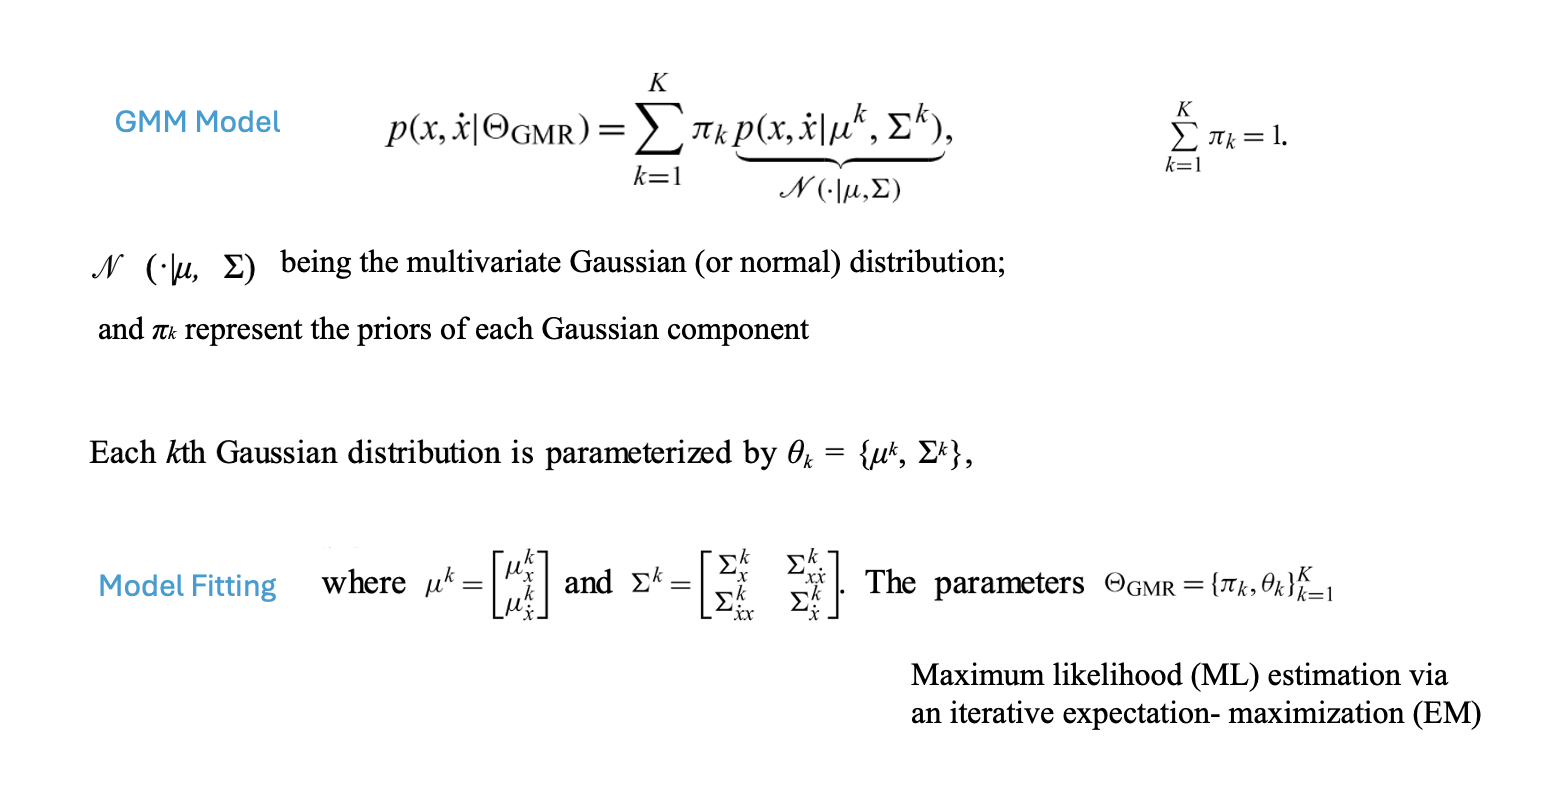

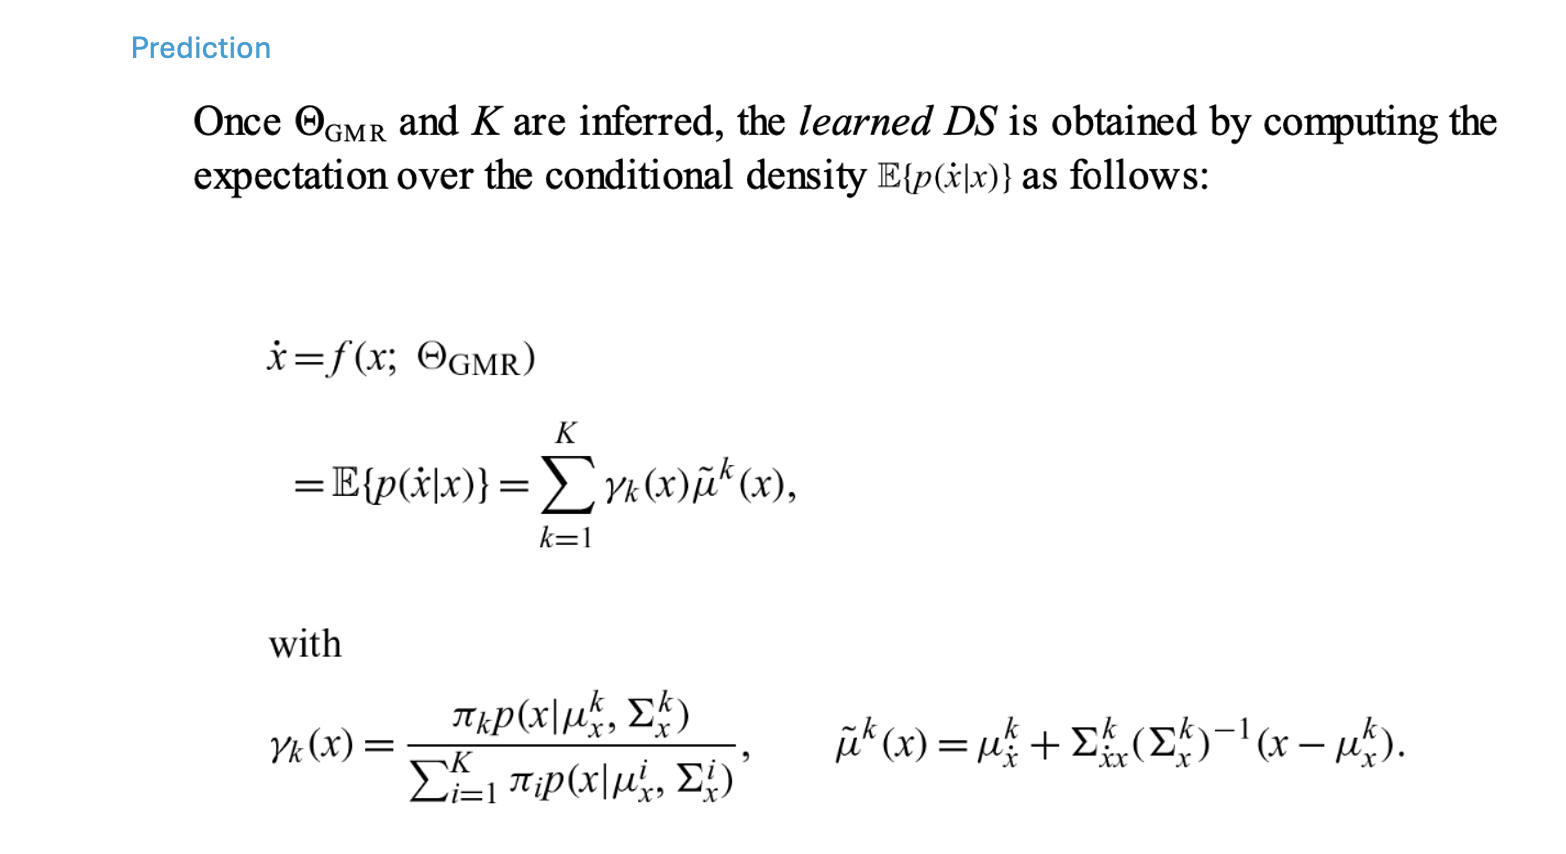

In [4]:
class GMR:
    def __init__(self,n_mixture):
        '''
        params:
            n_mixture: number of gaussians
        '''
        self.gmm = gmr.GMM(n_mixture)

    def fit(self,X,Y):
        '''
        the GMR package has EM algorithm that can be used to train the GMM

        params:
            X: data of shape (n_points,2)
            Y: X_dot of shape(n_points,2)
        '''
        Z = np.hstack([X,Y])
        self.gmm = self.gmm.from_samples(Z,n_iter=100,init_params="kmeans++")
        splot = plt.subplot(111)
        mvns = [gmr.MVN(mean=self.gmm.means[i][:2],covariance=self.gmm.covariances[i][:2,:2]) for i in range(len(self.gmm.priors))]
        plot_curves(data)
        splot = plt.subplot(111)
        for mvn in mvns:
            gmr.plot_error_ellipse(splot,mvn,factors=[1])
        print("posterioir:",self.gmm.priors)
        print("shapes of means:",self.gmm.means.shape)
        print("shapes of covariances:",self.gmm.covariances.shape)

    def predict(self,X):
        '''
        You can use the GMR package, or also can write your own code

        returns prediction from the model X_dot

        params:
            X: array of shape (n_points,2)
        returns:
            predicted X_dot: array of shape (n_points,2)
        '''
        ################################
        #YOUR CODE HERE (you cannot use gmm.predict or gmm.condition, use the formula for conditioning of gaussian mixture)


        ################################

    def ode_differential(self,x,t):
        '''
        function used for rk4 simulation
        '''
        return self.predict(x[None])[0]


    def rk4_sim(self,t0,t_end,x0,f,dt=1e-3):
        '''
        simlution done with rk4

        Returns
        -------
        x : shape (n_steps,self.d)
        t : shape - (n_steps,)
        '''
        # Calculate slopes
        x,t = x0,t0
        x_list,t_list = [x0],[t0]
        while t<=t_end:
            k1 = dt*f(x,t)
            k2 = dt*f(x+k1/2.,t+dt/2. )
            k3 = dt*f(x+k2/2.,t+dt/2. )
            k4 = dt*f(x+k3 , t+dt )

            # Calculate new x and y
            x = x + 1./6*(k1+2*k2+2*k3+k4)
            t = t + dt
            x_list.append(x)
            t_list.append(t)

        return np.array(x_list),np.array(t_list)

    def imitate(self,x0,t_end=5):
        '''
        imitation with new starting point

        Parameters
        ----------
        x0  - starting point - shape (self.d,)

        Returns
        -------
        x_rk4 - simulated data  - shape (n_steps,self.d)
        t_rk4 - time - shape (n_steps,)
        '''
        f = self.ode_differential
        return self.rk4_sim(0,t_end,x0,f)


In [ ]:
#fitting the model to data
model = GMR(10)
model.fit(x,xd)


In [6]:

#starting point for imitation
x0 = data[0][0]
x_rk4,t_tk4 = model.imitate(x0,t_end=10)

In [ ]:

#plots for generated trajectory
plt.figure(figsize=(10,5))
plot_curves(data,alpha=0.3,c="g",label="demonstrations")
plot_curves(x_rk4[None],show_start_end=False,label="generated trajectory")


In [ ]:
#vector field plot using stream line
plt.figure(figsize=(10,5))
plot_curves(data,alpha=0.5,c="b",label="demonstrations")
streamplot(model.predict,x_axis=(min(x[:,0])-15,max(x[:,0])+15),y_axis=(min(x[:,1])-15,max(x[:,1])+15),width=3,color="g")

#Fit the model to each of the data set and answer the following questions:

**For "C" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans:

**For "J" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans:

**For "S" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans:

In [ ]:
####################
#YOUR CODE HERE FOR ANSWERING THE ABOVE QUESTIONS
####################

# Submission details

please submit the copy of this file with the naming convention **SRNO(5digit)_Assignment5.ipynb**